In [64]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [66]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [67]:
filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Training")
categories = []
for filename in filenames:
    category = filename[0]
    if category == "3":
        categories.append("triangle")
    elif category == "4":
        categories.append("square")
    elif category == "5":
        categories.append("pentagon")
    elif category == "6":
        categories.append("hexagon")
    elif category == "7":
        categories.append("heptagon")
    elif category == "8":
        categories.append("octagon")
    elif category == "9":
        categories.append("nonagon")
    else:
        categories.append("decagon")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

#This line used to shuffle the dataset
df = df.sample(frac=1)


In [68]:
df.to_csv(r"C:\Users\nguyent2\Desktop\New.csv")
df.head()

,filename,category
9170,10_sides_9251.png,decagon
24723,4_sides_5249.png,square
39558,5_sides_9600.png,pentagon
56781,7_sides_7100.png,heptagon
19039,3_sides_9133.png,triangle


In [69]:
df.tail()

,filename,category
8148,10_sides_8331.png,decagon
27888,4_sides_8098.png,square
28813,4_sides_8930.png,square
63884,8_sides_4494.png,octagon
30062,5_sides_1053.png,pentagon


<AxesSubplot:>

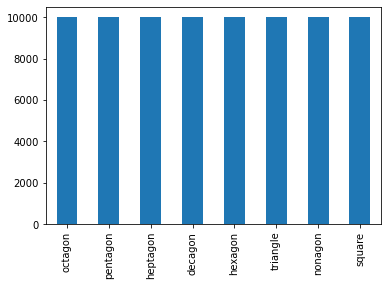

In [70]:
df['category'].value_counts().plot.bar()

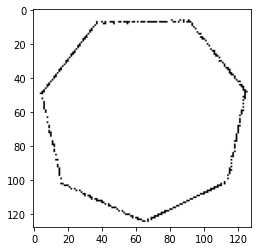

In [71]:
sample = random.choice(filenames)
image = load_img(r"C:\Users\nguyent2\Desktop\Training\\" + sample)
plt.imshow(image)

In [72]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

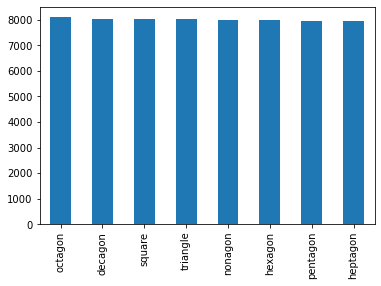

In [73]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

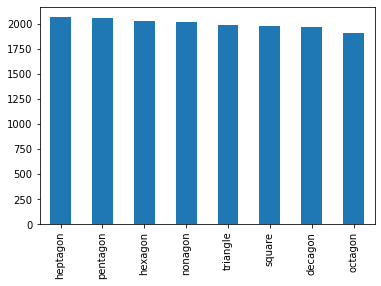

In [74]:
validate_df['category'].value_counts().plot.bar()

In [75]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [76]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size= batch_size
)

Found 64000 validated image filenames belonging to 8 classes.


In [77]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 16000 validated image filenames belonging to 8 classes.


In [78]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,   r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [79]:
plt.figure(figsize=(128, 128))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [86]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [89]:
model = Sequential()
model.add(Conv2D(100 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 128, 100)     2800      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 100)     400       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 50)        45050     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64, 64, 50)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 50)        200       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 50)      

In [90]:
epochs=2 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks = [learning_rate_reduction, EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/5
   9/4266 [..............................] - ETA: 1:13:10 - loss: 1.1921e-07 - accuracy: 0.5917

KeyboardInterrupt: 

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

In [ ]:
plotLearningCurve(history,4)

In [ ]:
test_filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Testing")

test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\nguyent2\Desktop\Testing", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\nguyent2\Desktop\Testing\\"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()